### ALMA archival data notebook
Put this notebook out there for exploratory analysis of ALMA archival data (headers only). Puts a .tsv file from https://almascience.nrao.edu/asax/ into DataFrame form for ease of use with visualization libraries such as seaborn, matplotlib or bokeh.

python version 3.7.9

This is ongoing work, in the future I intend to put it into GUI form for interactive filtering.

-FBe


In [2]:
import numpy as np
import pandas as pd
import operator as op
import seaborn as sns
import matplotlib.pyplot as plt
import datetime




def multislice_df(df,col_list,op_list,val_list):
# Multi-column boolean slicing on a Pandas DataFrame. Uses a dictionary of comparison operators from the operator module
# Parameters: df : DataFrame
#             col_list : list of column names to be sliced.
#             op_list : operator (in string form) to be performed on the respective column, possible operators defined 
#             in op_dict.
#             val_list : list of values to compare each col. with (in the same order), can be str for a categorical col. 
#             as long as you use the '==' operator.
                
        
    
    op_dict = {'<':op.lt,'<=':op.le,'==':op.eq,
               '!=':op.ne,'>=':op.ge,'>':op.gt}
    temp = df
    
    for i in range(len(col_list)):
        temp = temp[op_dict[op_list[i]](temp[col_list[i]],val_list[i])]
    return temp
        

In [3]:
df = pd.read_csv('observation_1617827300.tsv',sep='\t',low_memory=False)
df['Mosaic'] = df['Mosaic']=='mosaic' #turn into bool
df['Footprint'] = df['Footprint'].str.split().str.get(0) #Get the first word: Circle, Polygon, Union
df.drop(['Collections'],axis=1,inplace=True)
df['Year'] = df['Obs. date'].str[:4]
df['Obs. date'] = pd.to_datetime(df['Obs. date'] ,yearfirst=True)

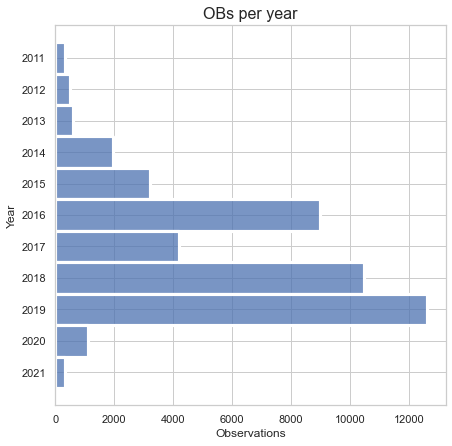

In [5]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(7,7))
ax = sns.histplot(y='Year',data=df)
ax.set_title('OBs per year',fontdict={'fontsize':16})
ax.set_xlabel('Observations')
plt.show()

Useful columns for array characterization: 
'Band' 'Cont. Sens' 'Publications' 'Ang. res.' 'Min. vel. res.'
'Array' 'Max. reco. scale' 'Int. time' 'Min. freq. res.' 'Obs. date'
'Line sens. (10 km/s)' 'Footprint' 'Year'

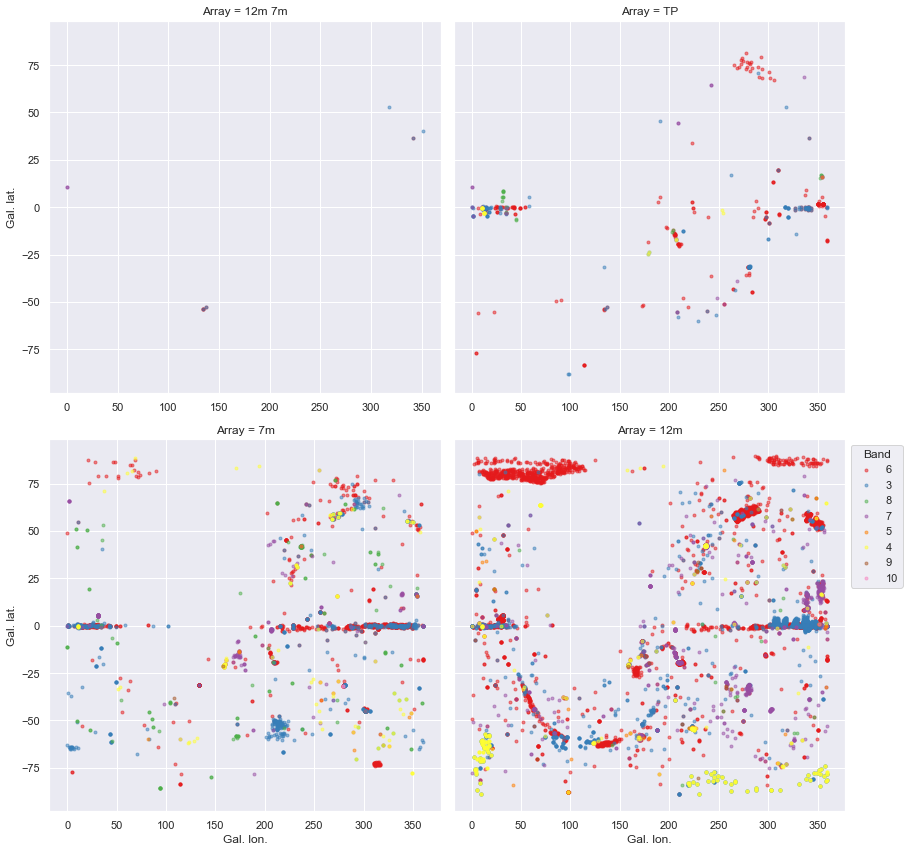

In [19]:
#lets play around with data from 2019
sns.set_theme(style='darkgrid')

data19=df[df['Year']=='2019']
g = sns.FacetGrid(data19,col='Array',hue='Band',col_wrap=2, height=6,
              sharex=False, sharey=True, despine=False,palette='Set1',col_order=['12m 7m','TP','7m','12m'])
g.map(plt.scatter, "Gal. lon.", "Gal. lat.",alpha=0.5,marker='.')

plt.legend(title='Band',bbox_to_anchor=(1,1))
plt.show()

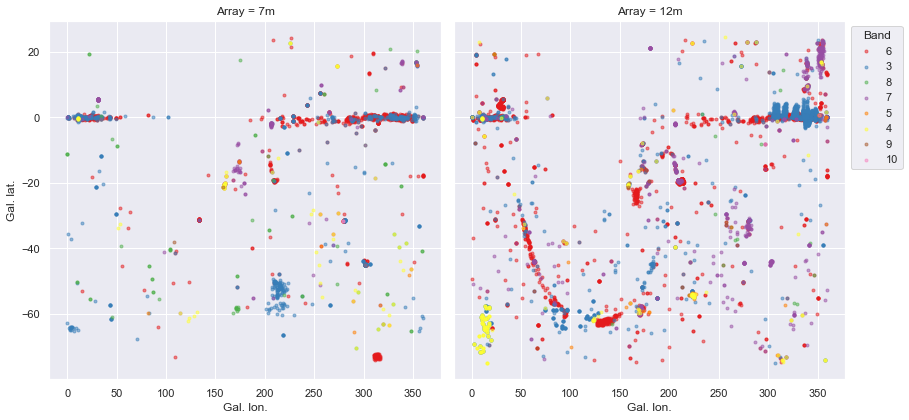

In [24]:
#zoom-in on arrays 7m, 12m
flt19= multislice_df(data19,
              ['Array','Array','Gal. lat.','Gal. lat.'],
              ['!=','!=','>=','<='],
              ['12m 7m','TP',-75,25])
g = sns.FacetGrid(flt19,col='Array',hue='Band',col_wrap=2, height=6,
              sharex=False, sharey=True, despine=False,palette='Set1')
g.map(plt.scatter, "Gal. lon.", "Gal. lat.",alpha=0.5,marker='.')
plt.legend(title='Band',bbox_to_anchor=(1,1))
plt.show()

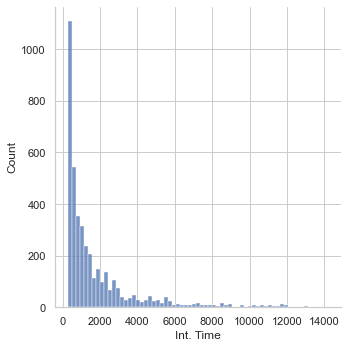

In [51]:
#check the Int. Time distribution of OBs with  300 <= t <= 14400
sns.set_theme(style='whitegrid')
flt19= multislice_df(data19,
              ['Array','Array','Int. Time','Int. Time'],
              ['!=','!=','<=','>='],
              ['12m 7m','TP',14400,300])
ax=sns.displot(x='Int. Time',data=flt19)
plt.show()


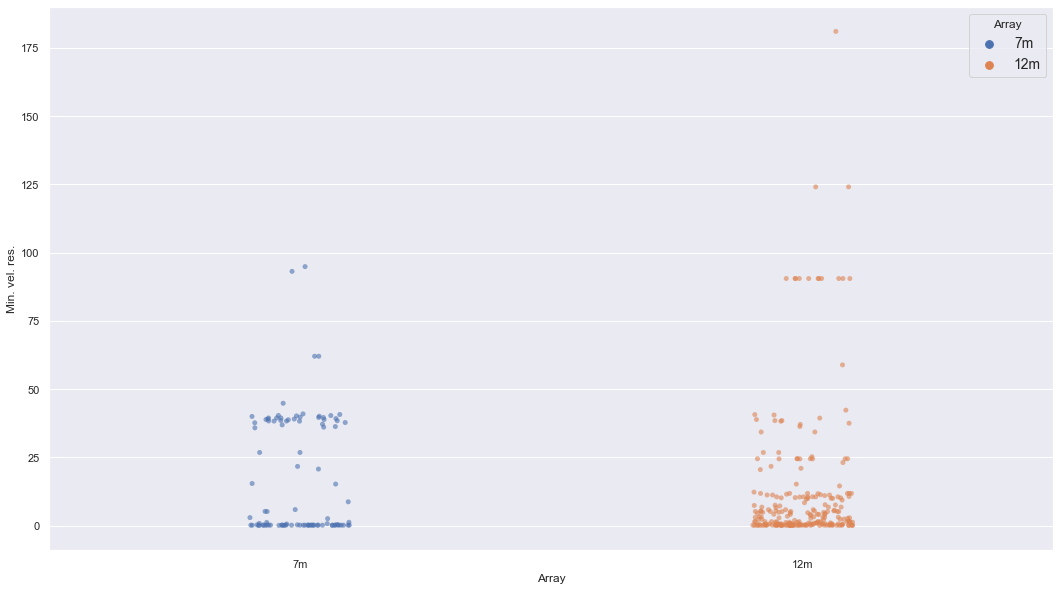

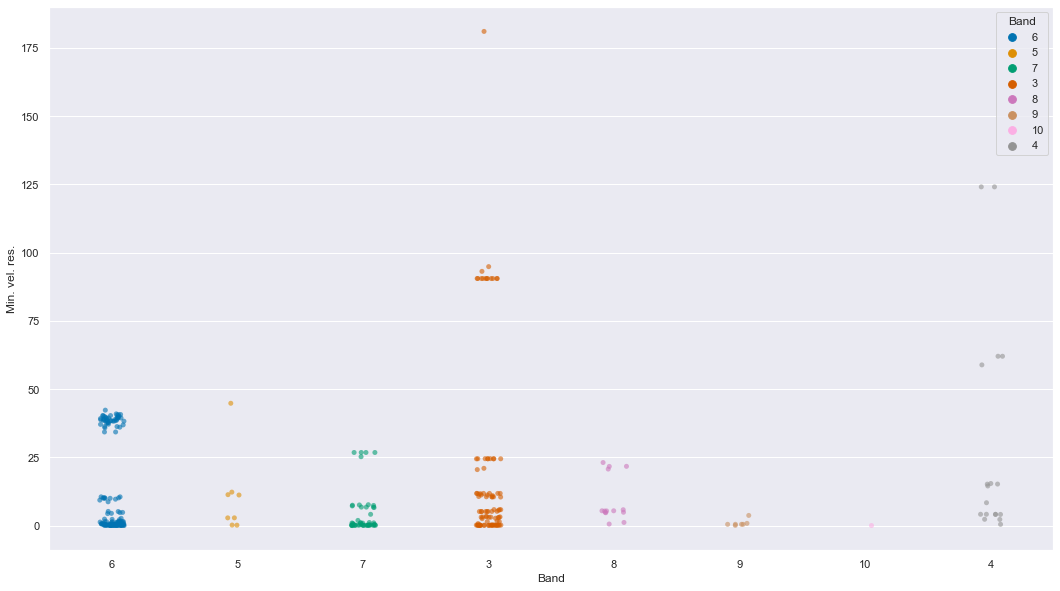

In [66]:
#further filter between 2400s and 3600 and show Minimum velocity resolution along different arrays and bands
sns.set_theme(style='darkgrid')
plt.figure(figsize=(18,10))
flt19= multislice_df(flt19,
              ['Int. Time','Int. Time'],
              ['<=','>='],
              [3600,2400])
ax = sns.stripplot(x='Array',y='Min. vel. res.',alpha=0.6,hue='Array',data=flt19)

plt.legend(title='Array',fontsize=14)
plt.show()
plt.figure(figsize=(18,10))
flt19= multislice_df(flt19,
              ['Int. Time','Int. Time'],
              ['<=','>='],
              [3600,2400])
ax = sns.stripplot(x='Band',y='Min. vel. res.',alpha=0.6,hue='Band',data=flt19,palette='colorblind')
plt.show()

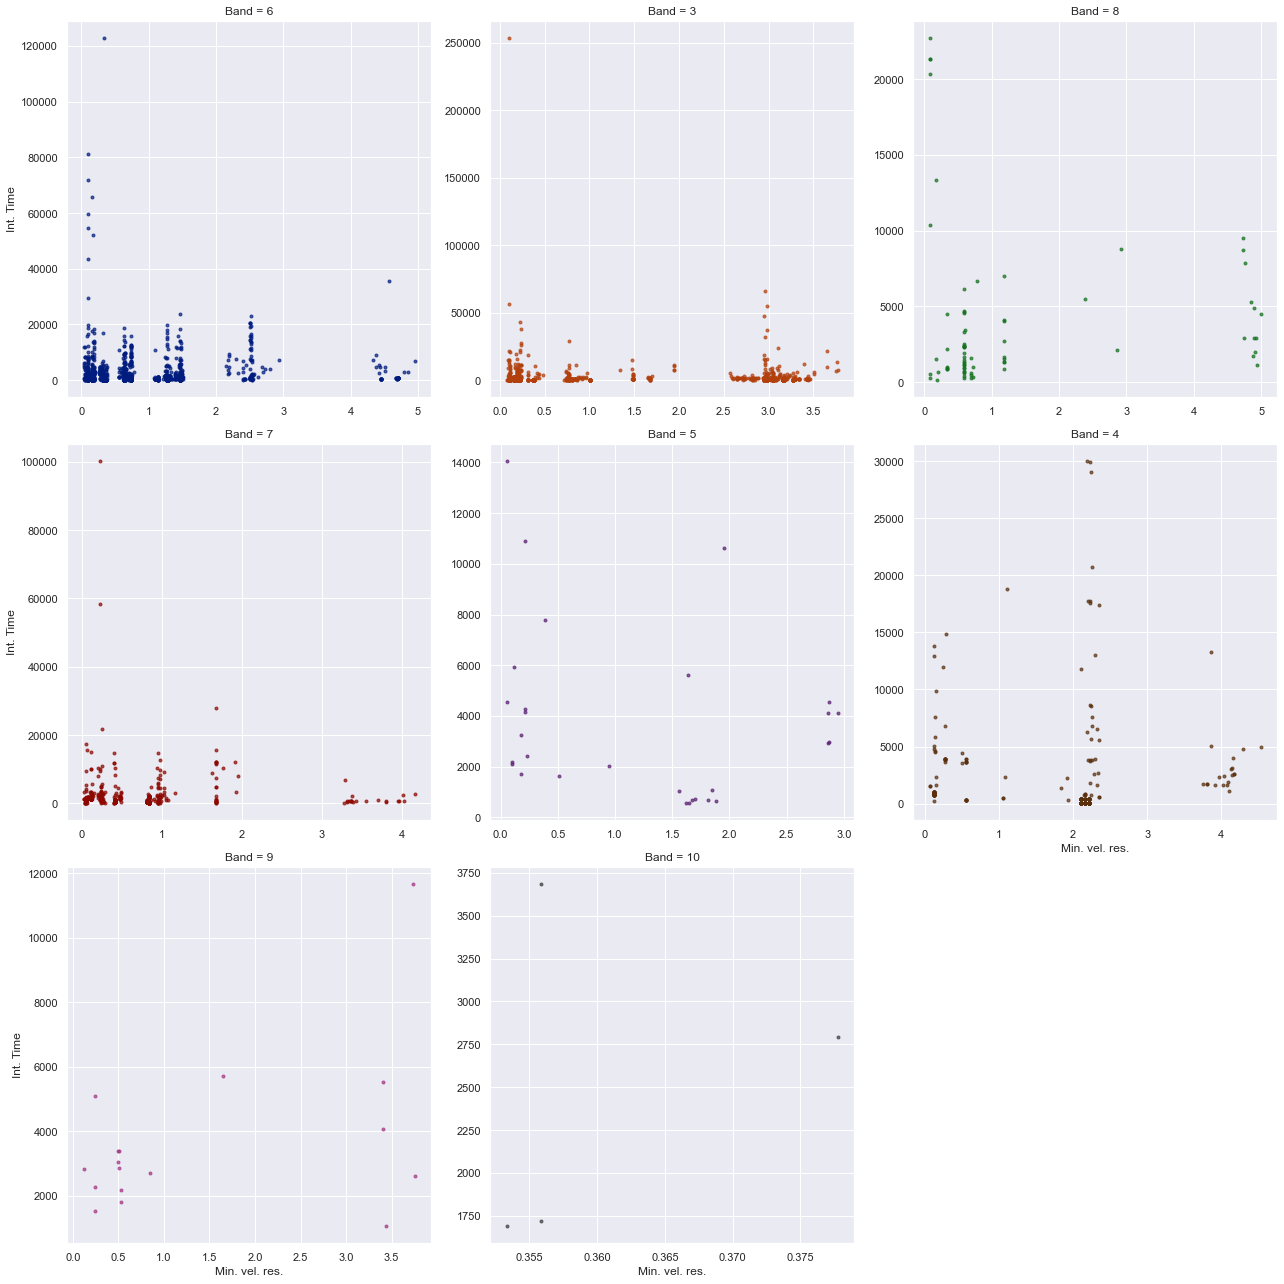

In [68]:
#What if we want to see the integration times for observations with resolution better than 5 km/s?
hi_res = data19[data19['Min. vel. res.']<=5]

g = sns.FacetGrid(hi_res,col='Band',hue='Band',col_wrap=3, height=6,palette='dark',
              sharex=False, sharey=False, despine=False)
g.map(plt.scatter, 'Min. vel. res.', 'Int. Time',alpha=0.7,marker='.')
plt.show()

In [69]:
#check those outliers:
pd.set_option('max_columns', None)
hi_res[hi_res['Int. Time']>100000].head()

,Project code,ALMA source name,Ra,Dec,Band,Cont. sens.,Frequency support,Release date,Publications,Ang. res.,Min. vel. res.,Array,Mosaic,Max. reco. scale,FOV,Scientific category,Science keyword,Int. Time,Gal. lon.,Gal. lat.,Min. freq. res.,Pol products,Obs. date,PI name,SB name,Proposal authors,Line sens. (10 km/s),PWV,Group ous id,Member ous id,Asdm,Project title,Type,Scan intent,QA2 Status,Footprint,Year
42018,2019.1.01556.S,SDC13,273.623340,-17.541944,3,0.299652,"[90.62..90.68GHz,30.52kHz,10.88mJy/beam@10km/s...",2021-08-18,0,53.479399,0.098158,TP,False,947.949205,59.246826,ISM and star formation,"High-mass star formation, Inter-Stellar Medium...",253543.102,13.175055,-0.070586,30.513185,XX YY,2019-10-13,"Williams, Gwenllian",SDC13_a_03_TP,"Peretto, Nicolas; Fuller, Gary; Thompson, Mark...",10.237941,3.857798,uid://A001/X1465/X839,uid://A001/X1465/X840,85,On the universality of fibres in star forming ...,S,TARGET,PASS,Polygon,2019
42789,2017.1.01355.L,G010.62,272.620167,-19.930083,6,0.367865,"[216.08..216.33GHz,244.14kHz,8.91mJy/beam@10km...",3000-01-01,1,23.385302,0.333211,TP,False,414.517065,25.907317,ISM and star formation,"High-mass star formation, Low-mass star formation",122880.383,10.624097,-0.384095,244.106052,XX YY,2019-01-06,"Motte, Frederique",G010.62_a_06_TP,"Nguyen Luong, Quang; Bronfman, Leonardo; Henne...",8.123240,1.232240,uid://A001/X1296/X1da,uid://A001/X1296/X1e1,34,ALMA-IMF: ALMA transforms our view of the orig...,L,TARGET,SEMIPASS,Polygon,2019
42856,2019.1.00558.S,Horsehead,85.222917,-2.462500,7,1.044051,"[345.72..345.85GHz,282.23kHz,15.24mJy/beam@10k...",3000-01-01,0,14.889501,0.236476,TP,False,263.939240,16.496203,ISM and star formation,"Astrochemistry, Photon-Dominated Regions (PDR)...",100245.597,206.948879,-16.797462,282.219434,XX YY,2019-10-09,"Guzman, Viviana",Horsehea_a_07_TP,"Gerin, Maryvonne; Bron, Emeric; Schirmer, Thié...",14.426512,0.545894,uid://A001/X1465/X2bcb,uid://A001/X1465/X2bd0,42,Photo-erosion of molecular clouds: The Horsehead,S,TARGET,PASS,Polygon,2019


We can see that all 3 belong to Total Power Array. For anything involving integration times it's probably best to filter TP out or treat them separately.

Below we want to visualize which bands are effectively being used the most for each scientific category for:
+ all data
+ hi_res dataframe, ie: Int. Time:[2400:3600]s and Min. vel. res. <= 5 km/s

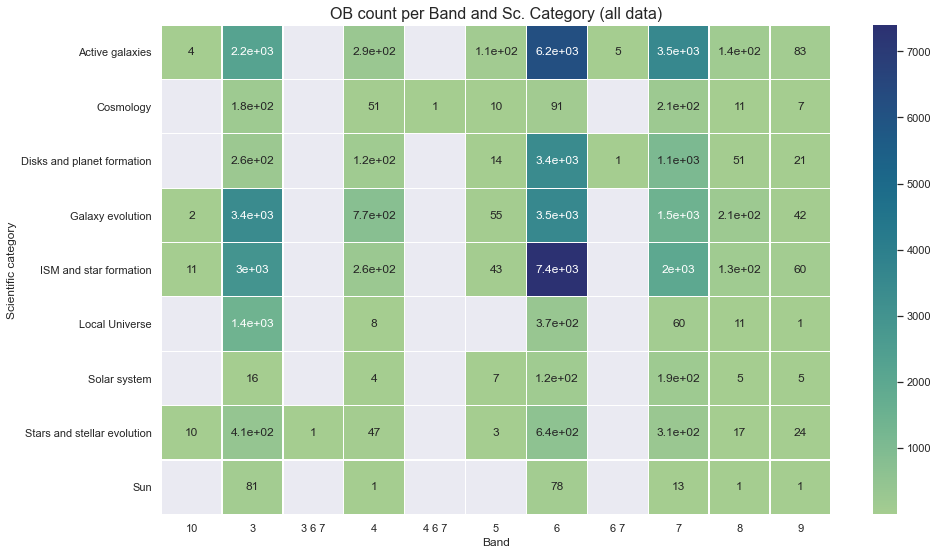

In [70]:
grid_df = df.groupby(['Scientific category','Band']).count().reset_index()[['Band','Ra','Scientific category']]
grid_pvt = grid_df.pivot_table(values='Ra',index='Scientific category',columns='Band')

sns.set(rc={'figure.figsize':(15.0,9.0)})
ax = sns.heatmap(grid_pvt,cmap="crest",linewidth=0.25,annot=True,
                    annot_kws={'size':12})
ax.set_title('OB count per Band and Sc. Category (all data)',fontdict={'fontsize':16})
plt.show()

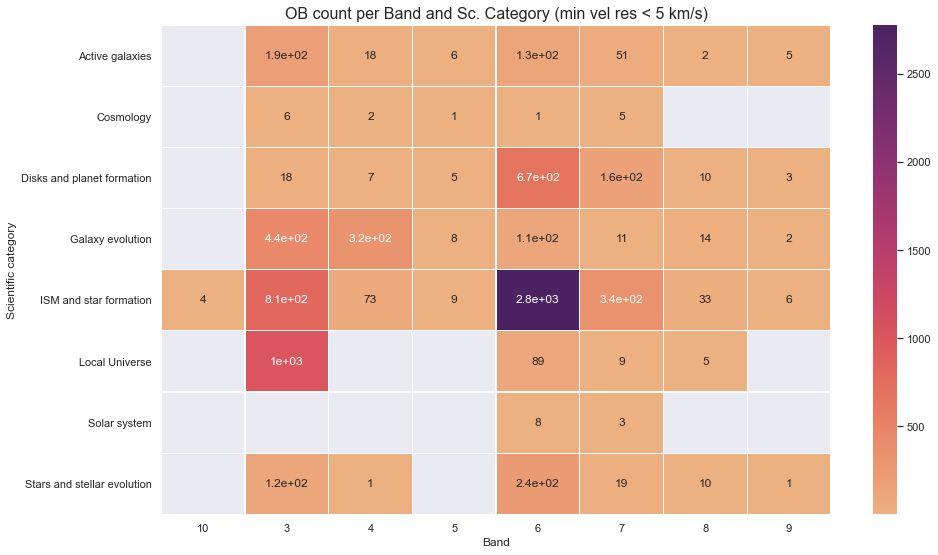

In [71]:
grid_df = hi_res.groupby(['Scientific category','Band']).count().reset_index()[['Band','Ra','Scientific category']]
grid_pvt = grid_df.pivot_table(values='Ra',index='Scientific category',columns='Band')

sns.set(rc={'figure.figsize':(15.0,9.0)})
ax = sns.heatmap(grid_pvt,cmap="flare",linewidth=0.25,annot=True,
                    annot_kws={'size':12})
ax.set_title('OB count per Band and Sc. Category (min vel res < 5 km/s)',fontdict={'fontsize':16})
plt.show()

Another interesting exploration would be scientific category vs year    

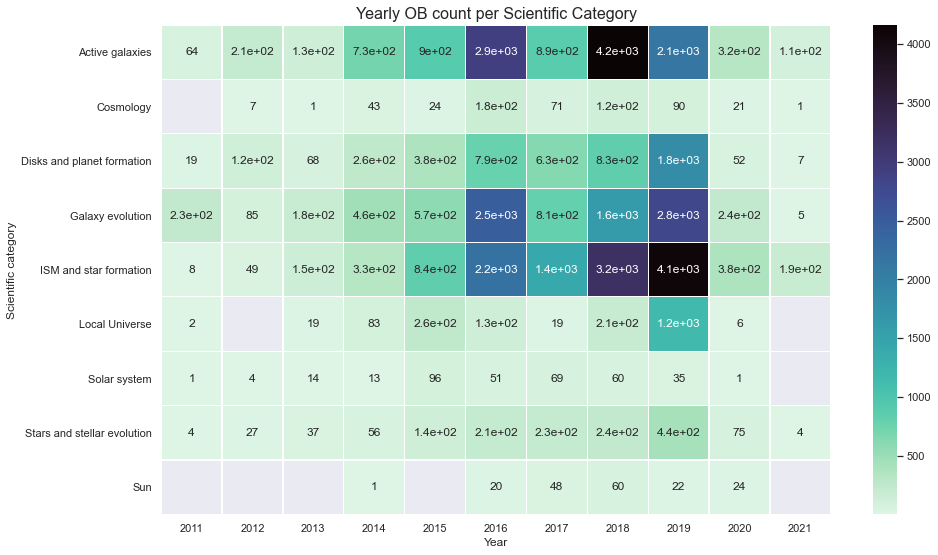

In [72]:
grid_df = df.sort_values('Year').groupby(['Scientific category','Year']).count().reset_index()[['Scientific category','Ra','Year']]
grid_pvt = grid_df.pivot_table(values='Ra',index='Scientific category',columns='Year')

sns.set(rc={'figure.figsize':(15.0,9.0)})
ax = sns.heatmap(grid_pvt,cmap='mako_r',linewidth=0.25,annot=True,
                    annot_kws={'size':12})
ax.set_title('Yearly OB count per Scientific Category',fontdict={'fontsize':16})
plt.show()